In [1]:
#%%
%load_ext autoreload
%autoreload 2

Retrying AEE in 1 sec...


,ticker,Previous Close
0,MMM,87.83
1,AOS,66.07
2,ABT,96.20
3,ABBV,147.45
4,ACN,309.66
5,ATVI,93.67
6,ADM,73.13
7,ADBE,516.44
8,ADP,243.36
9,AES,12.61


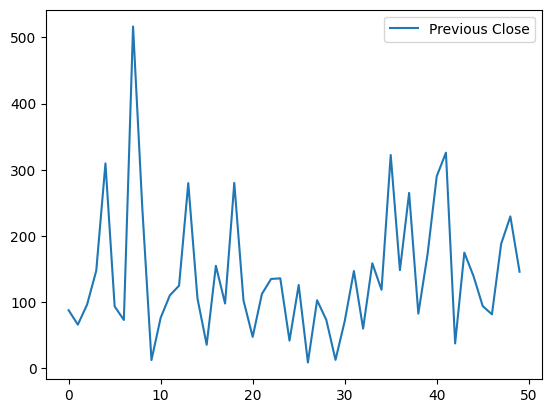

In [38]:
from bs4 import BeautifulSoup
import asyncio as aio
import pandas as pd
import aiohttp
import urllib.parse as urlparse

wiki_page_url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
finance_page_url = "https://finance.yahoo.com/quote/{symbol}?p={symbol}tsrc=fin-srch"
stat_page_url = "https://finance.yahoo.com/quote/{symbol}/key-statistics?p={symbol}"

user_agent = "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/117.0.0.0 Safari/537.36"

def get_host(url: str):
  parsed_url = urlparse.urlparse(url)
  return parsed_url.netloc

async def get_symbols(session: aiohttp.ClientSession):
  async with session.get(wiki_page_url, headers={'Accept': 'text/html', 'Host': get_host(wiki_page_url), "User-Agent": user_agent}) as response:
    # Get the HTML content
    html = await response.text('UTF-8')

    # Parse the HTML content
    soup = BeautifulSoup(html, 'html.parser')

    # Find symbol names inside the table
    table = soup.find('table', {'id': 'constituents'})
    symbol_links = table.find('tbody').select('tr td:nth-of-type(1) a')
    symbol_names = [link.text for link in symbol_links] # Extract the text from the HTML anchor element

    # Cut the list to take only the first 50 elements.
    symbol_names = symbol_names[:50]

    return symbol_names

async def get_prev_close_value(session: aiohttp.ClientSession, symbol_name: str, retries: int = 3):
  url = finance_page_url.format(symbol=urlparse.quote(symbol_name))
  async with session.get(url, headers={'Accept': 'text/html', 'Host': get_host(url), 'User-Agent': user_agent}) as response:
    if response.status != 200:
      if retries > 0:
        print(f"Retrying {symbol_name} in 1 sec...")
        await aio.sleep(1)
        return await get_prev_close_value(session, symbol_name, retries - 1)
      
      print(f"Could not get previous close value for {symbol_name}")
      print(f"Status code: {response.status} ({response.reason}) - {url}")
      print(response.request_info.headers)
      return None

    # Get the HTML content
    html = await response.text('UTF-8')

    # Parse the HTML content
    soup = BeautifulSoup(html, 'html.parser')

    # Find previouse close value
    prev_close_td = soup.select_one('td[data-test="PREV_CLOSE-value"]')

    prev_close_value = prev_close_td.text

    return float(prev_close_value)

async with aiohttp.ClientSession() as session:
  symbol_names = await get_symbols(session)
  
  # Create a task for each symbol name
  prev_close_tasks = [get_prev_close_value(session, symbol_name) for symbol_name in symbol_names]

  # Wait for all tasks to complete (this is a blocking operation)
  prev_close_values = await aio.gather(*prev_close_tasks)

  df = pd.DataFrame({
    'ticker': symbol_names,
    'Previous Close': prev_close_values
  })

  display(df)